In [4]:
# Download data 
# !wget https://raw.githubusercontent.com/borisbanushev/predictions/master/data/usdinr_dataset.csv
# !wget https://raw.githubusercontent.com/borisbanushev/predictions/master/data/Google_Stock_Price_Train.csv

# !ls -a

In [1]:
from pandas import read_csv
from pandas import datetime
from pandas import concat
from pandas import DataFrame
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt
from keras import regularizers
import pandas as pd
from keras.utils.vis_utils import plot_model
# from pandas.tools.plotting import lag_plot
from pandas import Series
from pandas.tools.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

C:\Users\praveen ji\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from dateutil.parser import parse
from matplotlib import pyplot
import datetime

In [3]:

import time
import numpy as np

import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [4]:
# Load data frame 
CNHI = {"stock_name":"Microsoft", "data": pd.read_csv("MSFT.csv")}

#Inspect data 
CNHI['data'].tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
4028,2019-04-02,119.059998,119.480003,118.519997,119.190002,119.190002,18142300
4029,2019-04-03,119.860001,120.430000,119.150002,119.970001,119.970001,22860700
4030,2019-04-04,120.099998,120.230003,118.379997,119.360001,119.360001,20112800


In [5]:
CNHI['data'].head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-04-01,24.459999,24.700001,24.25,24.350000,17.652428,49803200
1,2003-04-02,25.100000,26.000000,25.10,25.719999,18.645597,68282500
2,2003-04-03,25.990000,26.090000,25.60,25.730000,18.652847,57394300


In [6]:
Predictors = pd.DataFrame({"sma2":CNHI["data"].Open.rolling(window=2).mean()})

Predictors["sma2_1"] = Predictors.sma2.shift(1)

Predictors["sma2_increment"] = Predictors.sma2.diff()

Predictors["sma2_1_increment"] = Predictors.sma2_1.diff()

Predictors["sma2_increment"] = Predictors.sma2.diff()  
 
Predictors["sma2_1_increment"] = Predictors.sma2_1.diff()  
 
Predictors["vol_increment"] = CNHI["data"].Volume.diff()
 
Predictors["vol_rel_increment"] = CNHI["data"].Volume.diff() / CNHI["data"].Volume
 
Predictors["open_1"] = CNHI["data"].Open.shift(1)
 
Predictors["open_incr"] = CNHI["data"].Open - CNHI["data"].Open.shift(1)
 
Predictors["open"] = CNHI["data"].Open

# Create 7 and 21 days Moving Average
Predictors['ma7'] = CNHI["data"].Open.rolling(window=7).mean()
Predictors['ma21'] = CNHI["data"].Open.rolling(window=21).mean()

# Create MACD
Predictors['26ema'] = CNHI["data"].Open.ewm(span=26).mean()# pd.ewma(dataset['price'], span=26)
Predictors['12ema'] = CNHI["data"].Open.ewm(span=12).mean()# pd.ewma(dataset['price'], span=12)
Predictors['MACD'] = (Predictors['12ema']-Predictors['26ema'])
    
# Create Bollinger Bands
Predictors['30 Day MA'] = CNHI["data"].Open.rolling(window=20).mean()
Predictors['30 Day STD'] = CNHI["data"].Open.rolling(window=20).std()
Predictors['upper_band'] = Predictors['30 Day MA'] + (Predictors['30 Day STD'] * 2)
Predictors['lower_band'] = Predictors['30 Day MA'] - (Predictors['30 Day STD'] * 2)
    
# Create Exponential moving average
Predictors['ema'] = CNHI["data"].Open.ewm(com=0.5).mean()
    
# Create Momentum
Predictors['momentum'] = CNHI["data"].Open-1
Predictors['log_momentum'] = np.log(Predictors['momentum'])
 
#Predictors = Predictors.dropna()

# Predictors.head()

In [7]:
CNHI['data'].shape

(4031, 7)

In [8]:
Predictors.shape

(4031, 21)

In [9]:
parentDataframe = pd.concat([CNHI['data'], Predictors], axis=1)

In [10]:
parentDataframe.shape

(4031, 28)

In [11]:
parentDataframe= parentDataframe.dropna()

In [12]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['sma2'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Microsoft - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()
    
    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()
    plt.show()

In [13]:
#plot_technical_indicators(Predictors, 400)

In [14]:
def getBinary(val):
    if val>0:
        return 1
    else:
        return 0

In [15]:
target = pd.DataFrame({"value":parentDataframe.sma2.shift(-1) - parentDataframe.sma2}).dropna()
X = (pd.merge(parentDataframe, target,left_index=True,right_index=True)[parentDataframe.columns])
y = pd.merge(parentDataframe, target,left_index=True,right_index=True)[target.columns]

X['Target'] = pd.DataFrame(y["value"].apply(getBinary))

#To be used for further for all evaluation purpose
X.rename(columns={'Date':'date'}, inplace=True)
X['date'] = X['date'].apply(lambda x: (parse(x).strftime('%Y/%m/%d')))
X=X.reset_index()
X.to_csv('FIwithTarget.csv',index=False)

# Saving a copy for future
parentDataframe = X.copy()

X.drop(['date','Target','index'],axis=1,inplace=True)
# print(X.head())

train_samples = int(X.shape[0] * 0.65)
 
X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]
 
y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

y_test_binary = pd.DataFrame(y_test["value"].apply(getBinary))

In [16]:
type(X)

pandas.core.frame.DataFrame

In [17]:
X.shape

(4010, 27)

In [18]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.01)


xgbModel = regressor.fit(X_train,y_train.value.apply(getBinary))
 
y_predicted = xgbModel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted] # (y_predicted > 0.5)
 
print ('Model accuracy = %.3f' % accuracy_score(y_test_binary,y_predicted_binary))

print('classification_score\n',classification_report(y_test_binary, y_predicted_binary))

Model accuracy = 0.746
classification_score
               precision    recall  f1-score   support

           0       0.69      0.77      0.73       629
           1       0.80      0.72      0.76       775

   micro avg       0.75      0.75      0.75      1404
   macro avg       0.75      0.75      0.75      1404
weighted avg       0.75      0.75      0.75      1404



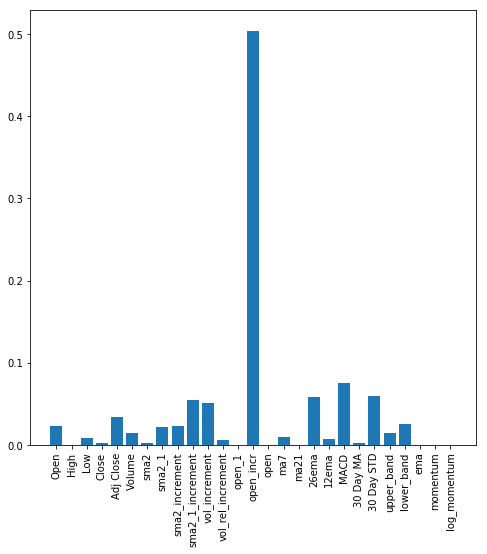

In [19]:
fig = pyplot.figure(figsize=(8,8))
pyplot.xticks(rotation='vertical')
pyplot.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns)
pyplot.show()

# Second Round of addition of financial indicator

In [19]:

# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

AUC: 0.815


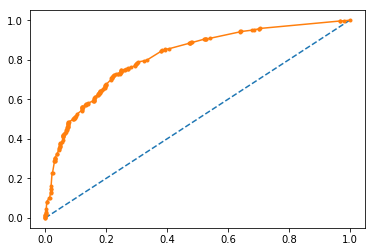

In [20]:
# calculate AUC
auc = roc_auc_score(y_test_binary, y_predicted)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_predicted)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [21]:
#Fourier transforms for trend analysis

In [20]:
close_fft = np.fft.fft(X.Open.tolist())
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

C:\Users\praveen ji\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


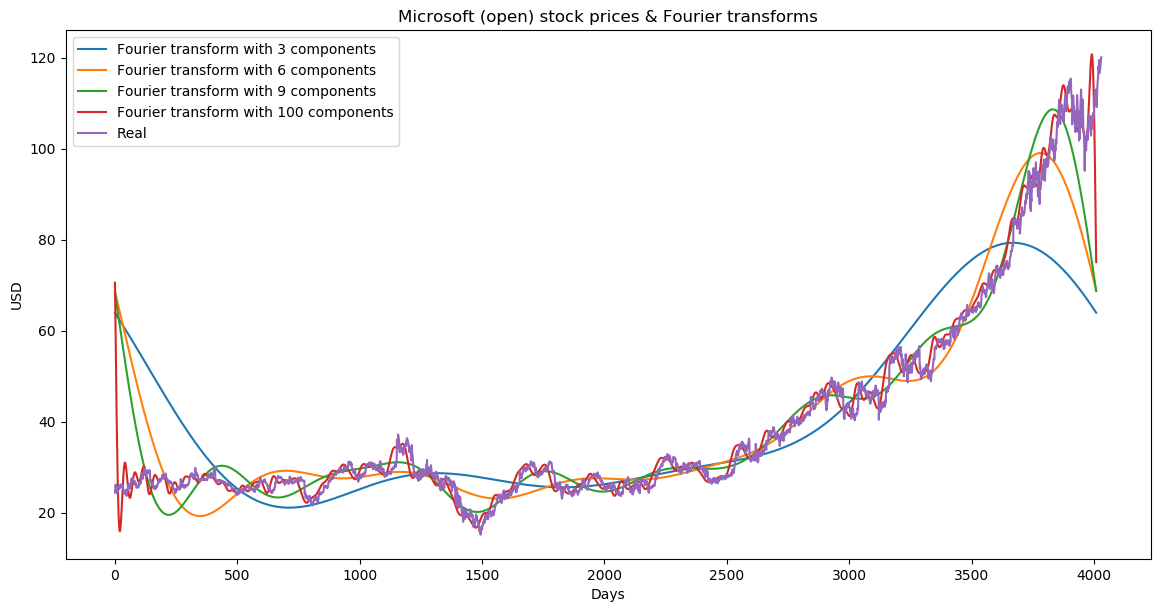

In [21]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(CNHI["data"].Open,  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Microsoft (open) stock prices & Fourier transforms')
plt.legend()
plt.show()

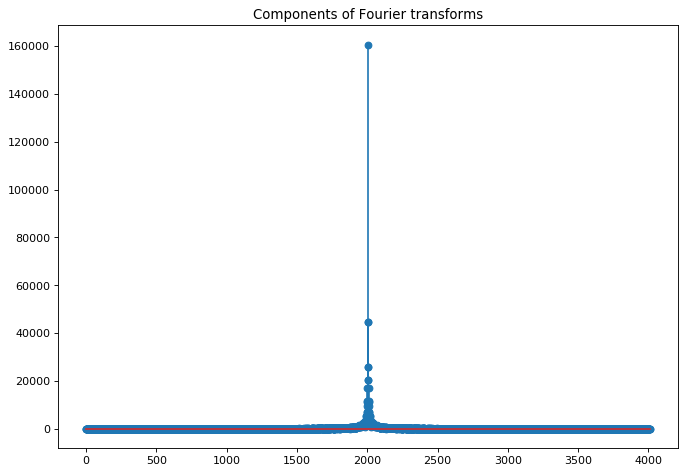

In [22]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Components of Fourier transforms')
plt.show()

In [23]:
X.shape

(4010, 27)

In [24]:
X['fft'] = fft_df.fft.tolist()
X['absolute'] = fft_df.absolute.tolist()
X['angle'] = fft_df.angle.tolist()

In [25]:
type(fft_df.fft[0])

numpy.complex128

In [26]:
float(fft_df.fft[0])

C:\Users\praveen ji\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


160508.460101

In [27]:
X['fft'] = X['fft'].astype(float)

C:\Users\praveen ji\Anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:730: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [28]:
X.shape

(4010, 30)

In [29]:
X.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'sma2', 'sma2_1',
       'sma2_increment', 'sma2_1_increment', 'vol_increment',
       'vol_rel_increment', 'open_1', 'open_incr', 'open', 'ma7', 'ma21',
       '26ema', '12ema', 'MACD', '30 Day MA', '30 Day STD', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum', 'fft', 'absolute',
       'angle'],
      dtype='object')

In [30]:
type(X)

pandas.core.frame.DataFrame

In [31]:
X['date'] = parentDataframe.date.tolist()
X['Target'] = parentDataframe.Target.tolist()

In [32]:
parentDataframe = X.copy()
X.to_csv('FIwithTargetwithFTT.csv',index=False)

# ARIMA as a feature

In [23]:
X = pd.read_csv('FIwithTargetwithFTT.csv')

In [72]:
def getDataset(result):
    #train and test split
    train_nw = result[result['date'] < pd.to_datetime('2018/06/01')]
    test_nw = result[result['date'] >= pd.to_datetime('2018/06/01')]

    train_nw_y = train_nw['target']
    test_nw_y = test_nw['target']

    train_nw.drop(['date','target'],axis=1,inplace=True)
    test_nw.drop(['date','target'],axis=1,inplace=True)
    return train_nw, test_nw, train_nw_y, test_nw_y

In [64]:
X.shape

(4007, 32)

In [65]:
X.date = pd.to_datetime(X.date)

In [66]:
X.rename(columns={'Target':'target'}, inplace=True)

In [67]:
train_nw, test_nw, train_nw_y, test_nw_y = getDataset(X)

C:\Users\praveen ji\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [68]:
print('train_nw',train_nw.shape,'test_nw',test_nw.shape,'len(train_nw_y)',len(train_nw_y),'len(test_nw_y)',len(test_nw_y))

train_nw (27, 30) test_nw (3980, 30) len(train_nw_y) 27 len(test_nw_y) 3980


In [69]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = train_nw.Open
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\praveen ji\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\praveen ji\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\praveen ji\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                   26
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  -4.657
Method:                       css-mle   S.D. of innovations              0.284
Date:                Fri, 12 Apr 2019   AIC                             23.314
Time:                        15:26:30   BIC                             32.121
Sample:                             1   HQIC                            25.850
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0635      0.064     -0.988      0.335      -0.190       0.063
ar.L1.D.Open    -0.0571      0.204     -0.280      0.782      -0.457       0.343
ar.L2.D.Open     0.5718      0.210      2.72

C:\Users\praveen ji\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


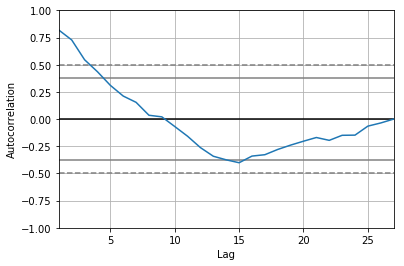

<Figure size 800x560 with 0 Axes>

In [70]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [73]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# X = series.values
size = int(len(X) * 0.66)
train = train_nw.Open.values
test = test_nw.Open.values
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

C:\Users\praveen ji\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\praveen ji\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\praveen ji\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

In [74]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.465


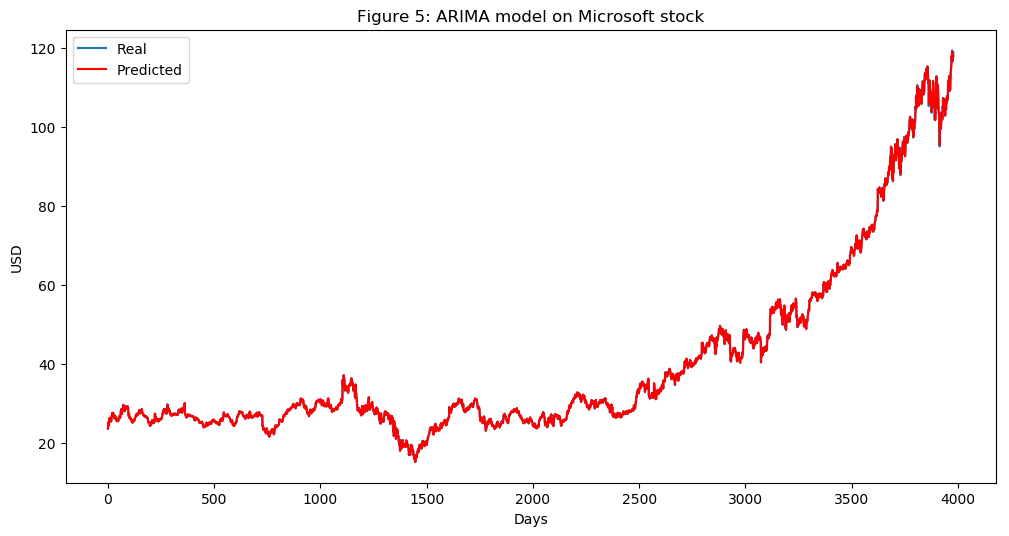

In [75]:
# Plot the predicted (from ARIMA) and real prices
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on Microsoft stock')
plt.legend()
plt.show()

In [28]:
def get_feature_importance_data(_df):
    data = _df.copy()
    y = data['target']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [26]:
X.shape

(4007, 32)

In [29]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(X)

In [30]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [33]:
xgbModel = regressor.fit(X_train_FI.drop(['date'],axis =1),y_train_FI, \
                         eval_set = [(X_train_FI.drop(['date'],axis =1), y_train_FI), (X_test_FI.drop(['date'],axis =1), y_test_FI)], \
                         verbose=False)

In [34]:
eval_result = regressor.evals_result()

In [35]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

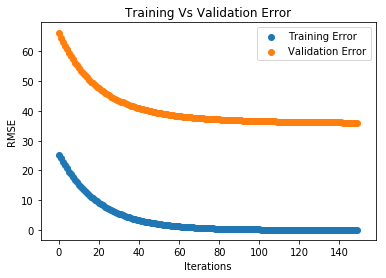

In [36]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()